# Entrenamiento de una red neuronal

Al entrenar una red buscamos que ésta tenga un comportamiendo presumiblemente adecuado y observable en un conjunto de datos. Es decír a partir del conjunto de ejemplos esperamos que la red aprenda una función $f$ tal que la salida de la red imite el patrón en los datos. En nuestro caso, al utilizar el conjunto de entrenamiento MNIST esperamos que la función aprendida provea como salida el número al cual corresponde la imagen de entrada.

<img src="archivos/function_approx.png">

Imagen tomada de [1]



## Retropropagación y Autograd

Pytorch provee el módulo *autograd* para calcular los gradientes, y si, !nos evita estar calculando las derivadas! Esto lo realiza a partir de mantener en la vista todas las operaciones que se ejecutan sobre los tensores.

Si deseas asegurarte que autograd siga a un tensor especificamos *requires_grad*. Esto se puede hacer en la creación o en cualquier momento. 

Veamos el siguiente código de ejemplo:

```python
# especificamos que la variable x es seguida por autograd
x = torch.zeros(1, requires_grad=True)
# si en algún momento desamos que temporalmente se deje de seguir el tensor usamos
>>> with torch.no_grad():
...     y = x * 2
# establecemos de nuevo el seguimiento
>>> y.requires_grad
```

Si queremos eliminar autograd de todos los tensores usamos `torch.set_grad_enabled(True|False)`.


Ahora bien, para calcular los gradientes simplemente usamos el método *backward()*. Por ejemplo para un tensor *cualquiera* hacemos *z.backward()*

Veamos a continuación el uso del gradiente.

In [1]:
# importamos paquetes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
# especificamos que el tensor x es seguido por autograd 
x = torch.randn(4, requires_grad=True)
print(x)

tensor([-0.3605,  0.6653, -0.9058, -1.6002], requires_grad=True)


In [3]:
# generamos un nuevo tensor a partir de x
# por ejemplo elevemos al cuadrado la variable x
y = x**2
print(y)

tensor([0.1299, 0.4426, 0.8205, 2.5606], grad_fn=<PowBackward0>)


In [4]:
## con grad_fn observamos la operación que generó y, es decir una operación potencia (pow)
print(y.grad_fn)


In [5]:
# De esta forma es posible saber las operaciónes que generan cada tensor, y por tanto, es posible calcular el gradiente.
# Hagamos ahora una operación de media
z = y.mean()
print(z)

tensor(0.9884, grad_fn=<MeanBackward0>)


In [6]:
# hasta este momento los gradientes son cero
print(x.grad)

None


Para calcular los gradientes es necesario llamar al método *.backward* sobre la variable. Supongamos sobre *z*. Esto calcula el gradiente de z con respecto de x.

El gradiente analítico de las operaciónes que hicimos es:
$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

Ahora comprobemos

In [7]:
z.backward()
print(x.grad)

print(x/2)

tensor([-0.1802,  0.3326, -0.4529, -0.8001])
tensor([-0.1802,  0.3326, -0.4529, -0.8001], grad_fn=<DivBackward0>)


## Conjunto de datos y red neuronal

Ahora descargemos los datos y generemos una red tal cual lo vimos en el notebook anterior. 

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Normalize([0.5],[0.5])
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [9]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

# NOTA solo calcularemos los logits y definiremos la perdida a partir de ellos

## Entrenamiento de la red

Lo primero que definiremos será la función de pérdida (loss) que es nombrada en pytorch como **criterion**. En este ejemplo estamos utilizando softmax, asi que definimos el criterio como *criterion = nn.CrossEntropyLoss()*. Más tarde, en el entrenamiento, veremos que *loss = criterion(output, targets)* calcula la pérdida.

Lo segundo que definiremos será el optimizador, para este ejemplo usaremos SGD (stochastic gradient descent). Simplemente llamamos a *torch.optim.SGD* y le pasamos los parámetros de la red y el lerning rate. 


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Antes de relizar el entrenamiento completo haremos un paso del aprendizaje. Este paso se compone de las siguientes tareas:

1. Realizar un pase frontal de la red
2. Utilizar los logits para calcular la pérdida
3. Realizar la retropropagación para calcular los gradientes.
4. Actualizar los pesos usando el optimizador.

Veamos el ejemplo


In [11]:
print('Initial weights - ', model.fc1.weight)


Initial weights -  Parameter containing:
tensor([[ 0.0320,  0.0320, -0.0152,  ..., -0.0146, -0.0243,  0.0337],
        [-0.0054,  0.0152, -0.0116,  ...,  0.0312, -0.0337, -0.0340],
        [ 0.0107,  0.0110, -0.0164,  ..., -0.0074,  0.0237,  0.0246],
        ...,
        [-0.0340, -0.0299, -0.0295,  ...,  0.0284,  0.0231, -0.0325],
        [-0.0001, -0.0007,  0.0217,  ..., -0.0302,  0.0290,  0.0221],
        [ 0.0140, -0.0025,  0.0348,  ..., -0.0214,  0.0345, -0.0017]],
       requires_grad=True)


In [12]:
images, labels = iter(trainloader).next()
images.resize_(64, 784)

# Limpiar los gradientes por que se acumulan
optimizer.zero_grad()

# Pase hacia adelante
output = model.forward(images)
# Perdida
loss = criterion(output, labels)
# Pase de reversa
loss.backward()
print('Gradient -', model.fc1.weight.grad)
# Actualiza los pesos de acuerdo a un paso del optimizador
optimizer.step()

Gradient - tensor([[ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        ...,
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027],
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [13]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0320,  0.0320, -0.0152,  ..., -0.0146, -0.0243,  0.0337],
        [-0.0054,  0.0152, -0.0116,  ...,  0.0312, -0.0336, -0.0339],
        [ 0.0107,  0.0110, -0.0164,  ..., -0.0074,  0.0237,  0.0246],
        ...,
        [-0.0340, -0.0299, -0.0294,  ...,  0.0285,  0.0231, -0.0325],
        [-0.0001, -0.0007,  0.0217,  ..., -0.0302,  0.0290,  0.0221],
        [ 0.0140, -0.0025,  0.0348,  ..., -0.0214,  0.0345, -0.0017]],
       requires_grad=True)


## Entrenamiento por épocas

Ahora si, entrenemos la red por varias épocas. Para ello programaremos el algoritmo de gradiente descendente que de forma general funciona con los siguientes pasos:

- Para un número de *épocas*:
    - Para cada *lote* en el conjunto de datos:
        - Salida = Red predice usando el *lote*
        - Calcular *pérdida* a partir de la *salida* y de las *etiquetas* reales
        - Error = Retropropagación a partir de la *pérdida*
        - Actualizar pesos
        
    

In [14]:
# configuración del optimizador
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [15]:
# hiperparámetro: número de épocas
epochs = 5
print_every = 40
steps = 0

for e in range(epochs):
    running_loss = 0
    # en cada iteración del for cargamos un batch
    for images, labels in iter(trainloader):
        steps += 1
        # Aplanar las imagenes de MNIST
        images.resize_(images.size()[0], 784)
        
        # Reiniciar el gradiente
        optimizer.zero_grad()
        
        # Pase frontal de la red
        output = model.forward(images)
        
        # Estimar la perdida
        loss = criterion(output, labels)
        
        # Backprogation
        loss.backward()
        
        # Actualizamos los pesos
        optimizer.step()
        
        # Guardamos la perdida para control del entrenamiento
        running_loss += loss.item()
        
        # imprimimos cada 40 lotes
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/5...  Loss: 2.2961
Epoch: 1/5...  Loss: 2.2736
Epoch: 1/5...  Loss: 2.2552
Epoch: 1/5...  Loss: 2.2343
Epoch: 1/5...  Loss: 2.2112
Epoch: 1/5...  Loss: 2.1819
Epoch: 1/5...  Loss: 2.1581
Epoch: 1/5...  Loss: 2.1181
Epoch: 1/5...  Loss: 2.0934
Epoch: 1/5...  Loss: 2.0538
Epoch: 1/5...  Loss: 2.0038
Epoch: 1/5...  Loss: 1.9668
Epoch: 1/5...  Loss: 1.9088
Epoch: 1/5...  Loss: 1.8657
Epoch: 1/5...  Loss: 1.8113
Epoch: 1/5...  Loss: 1.7516
Epoch: 1/5...  Loss: 1.6943
Epoch: 1/5...  Loss: 1.6202
Epoch: 1/5...  Loss: 1.5527
Epoch: 1/5...  Loss: 1.4948
Epoch: 1/5...  Loss: 1.4182
Epoch: 1/5...  Loss: 1.3578
Epoch: 1/5...  Loss: 1.3253
Epoch: 2/5...  Loss: 0.6951
Epoch: 2/5...  Loss: 1.1950
Epoch: 2/5...  Loss: 1.1275
Epoch: 2/5...  Loss: 1.0853
Epoch: 2/5...  Loss: 1.0241
Epoch: 2/5...  Loss: 0.9971
Epoch: 2/5...  Loss: 0.9750
Epoch: 2/5...  Loss: 0.9203
Epoch: 2/5...  Loss: 0.9001
Epoch: 2/5...  Loss: 0.8471
Epoch: 2/5...  Loss: 0.8274
Epoch: 2/5...  Loss: 0.7912
Epoch: 2/5...  Loss:

Finalmente, veamos que tan bien está clasificando la red

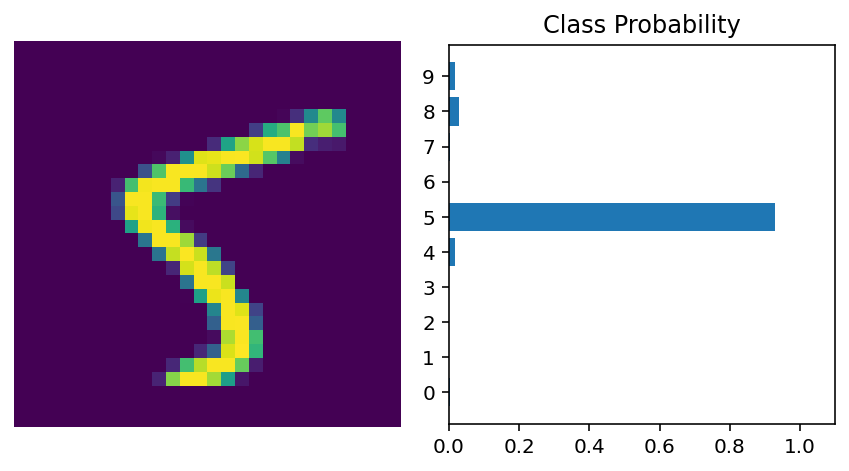

In [16]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

## Referencias

[1] Udacity Computer vision Nanodegree